# Lab 5: Clustering Techniques Using DBSCAN and Hierarchical Clustering  
**Name:** Sandesh Shrestha
**Course:** MSCS 634 – Advanced Big Data and Data Mining
**Assignment:** Lab 5 – Clustering (Wine Dataset)


In [1]:
# Step 1: Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score

from scipy.cluster.hierarchy import dendrogram, linkage

# Plot style
plt.rcParams["figure.figsize"] = (8, 6)
sns.set(style="whitegrid")


## Step 1: Data Preparation and Exploration

In this step, I load the Wine dataset from `sklearn`, explore its structure, and standardize the features so they are suitable for distance-based clustering algorithms.


In [2]:
# Load the Wine dataset
wine = load_wine()

X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = wine.target  # true class labels, used only for evaluation (not for training)

print("Shape of X:", X.shape)
print("Target classes:", np.unique(y))
X.head()


Shape of X: (178, 13)
Target classes: [0 1 2]


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [3]:
# Dataset structure
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [4]:
# Basic descriptive statistics
X.describe()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


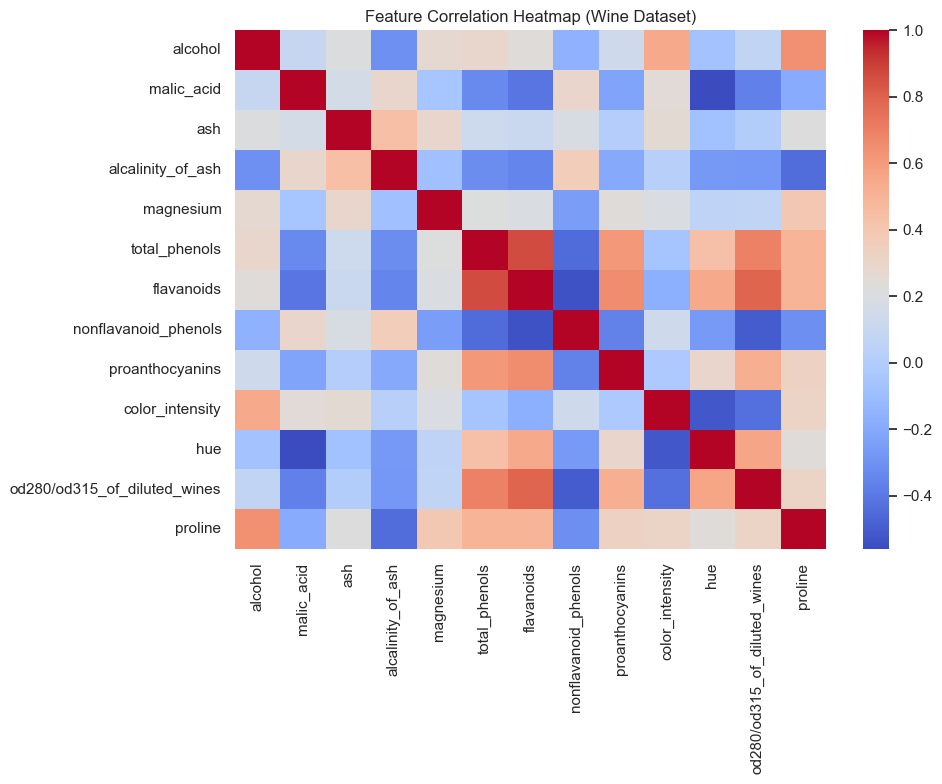

In [5]:
# Correlation heatmap to understand relationships between features
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap (Wine Dataset)")
plt.tight_layout()
plt.show()


### Interpretation of Data Exploration

- The dataset contains **178 samples** and **13 continuous features** describing different chemical properties of wine (e.g., alcohol, total_phenols, flavanoids, color_intensity, proline).
- The target variable has **3 wine classes** (0, 1, 2). These labels are not used during clustering, but will be helpful later when evaluating how well the clusters align with the true classes.
- The `.info()` output shows that:
  - All 13 columns are of type `float64`.
  - There are **no missing values** in any feature, so no imputation is required before clustering.
- The `.describe()` summary indicates that:
  - The features are on **very different scales**. For example, `alcohol` ranges roughly from 11 to 14, while `proline` ranges from about 280 to 1680.
  - Some variables, such as `color_intensity` and `proline`, have relatively wide ranges and higher standard deviations, suggesting they could dominate distance calculations if the data is not standardized.
- The correlation heatmap reveals several strong relationships:
  - `total_phenols`, `flavanoids`, and `od280/od315_of_diluted_wines` are **strongly positively correlated**, suggesting a shared underlying structure in how these phenolic compounds vary across wines.
  - `proanthocyanins` is also positively correlated with these phenolic features.
  - Some variables (such as `alcalinity_of_ash` and `magnesium`) show weaker or mixed correlations with the rest of the features.

Because hierarchical clustering and DBSCAN are **distance-based algorithms**, it is important to **standardize** the features so that:

- Features with larger scales do not dominate the distance computations.
- Correlated features do not overwhelm others purely due to their magnitude.
- Each feature contributes more equally to the clustering process, making the resulting clusters more meaningful.


In [6]:
# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check approximate mean and std of standardized features
print("Approximate mean of first 5 standardized features:", X_scaled.mean(axis=0)[:5])
print("Approximate std of first 5 standardized features:", X_scaled.std(axis=0)[:5])

Approximate mean of first 5 standardized features: [ 7.84141790e-15  2.44498554e-16 -4.05917497e-15 -7.11041712e-17
 -2.49488320e-17]
Approximate std of first 5 standardized features: [1. 1. 1. 1. 1.]


### Standardization

I used `StandardScaler` to transform each feature to have approximately **zero mean** and **unit variance**.  
This ensures that:

- No single feature dominates because of its scale.
- Distance calculations used by clustering algorithms are more meaningful.


## Step 2: Hierarchical Clustering (Agglomerative)

In this step, I apply **Agglomerative Hierarchical Clustering** to the standardized wine data.  
I will:

- Use PCA to reduce the data to 2 dimensions for visualization.
- Test multiple values of `n_clusters`.
- Visualize the clusters in 2D.
- Generate and interpret a dendrogram to understand the hierarchical structure.


Shape after PCA: (178, 2)


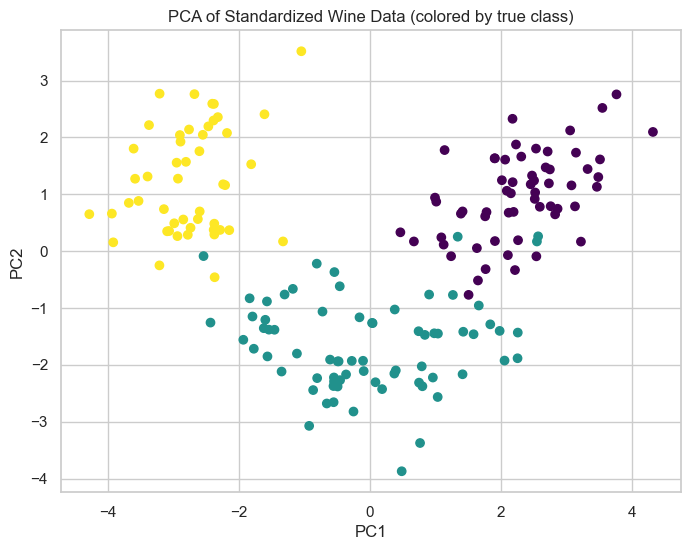

In [9]:
# PCA to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Shape after PCA:", X_pca.shape)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis")
plt.title("PCA of Standardized Wine Data (colored by true class)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


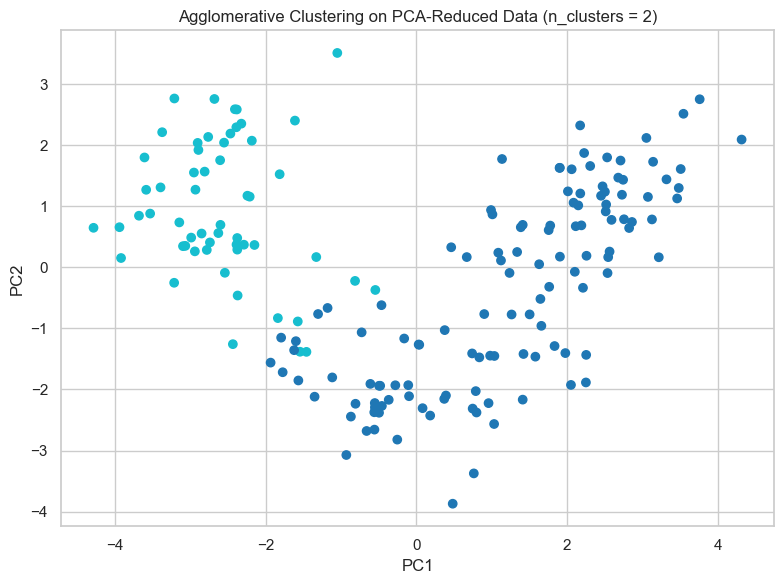

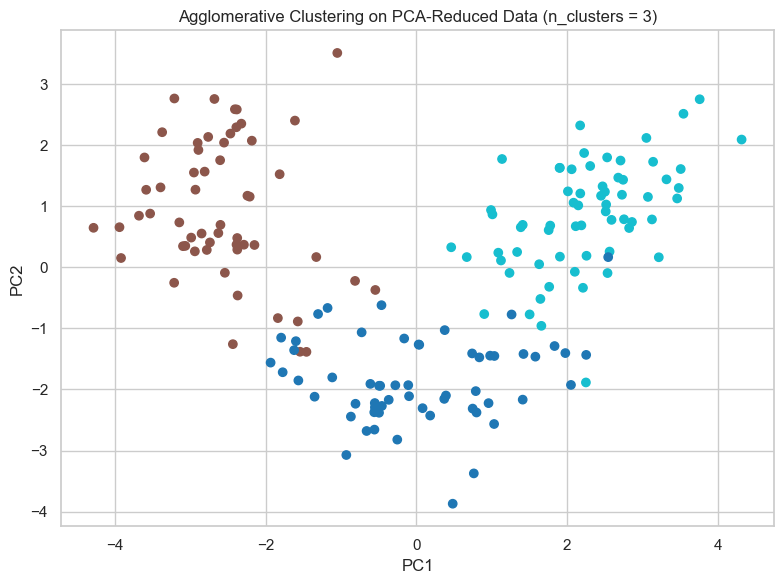

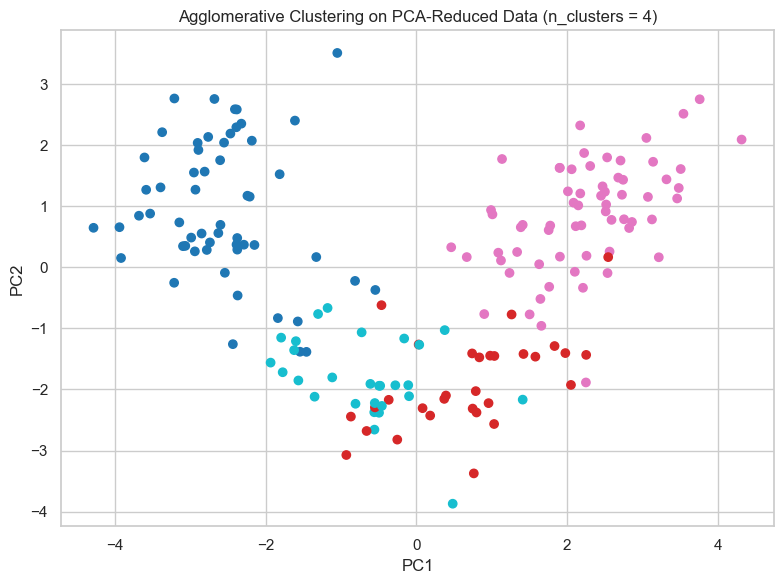

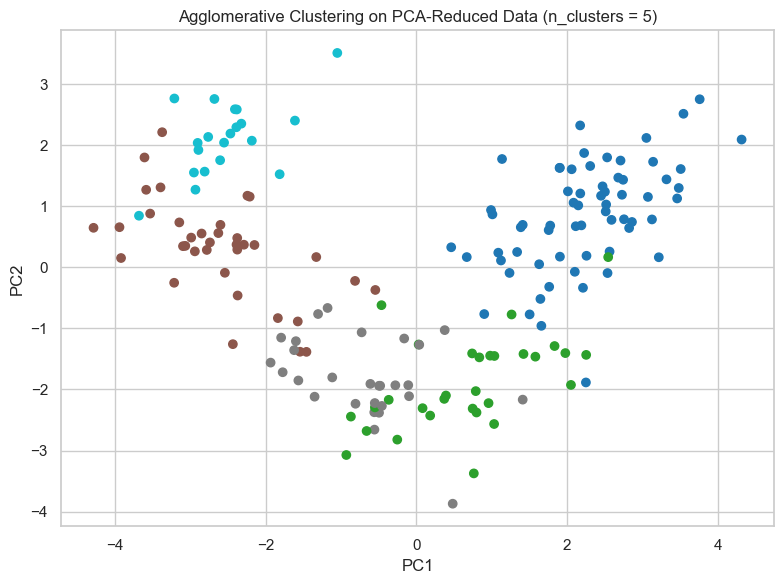

In [10]:
# Apply Agglomerative Clustering with different n_clusters
cluster_values = [2, 3, 4, 5]

for n_clusters in cluster_values:
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    agg_labels = agg.fit_predict(X_scaled)

    plt.figure()
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap="tab10")
    plt.title(f"Agglomerative Clustering on PCA-Reduced Data (n_clusters = {n_clusters})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()


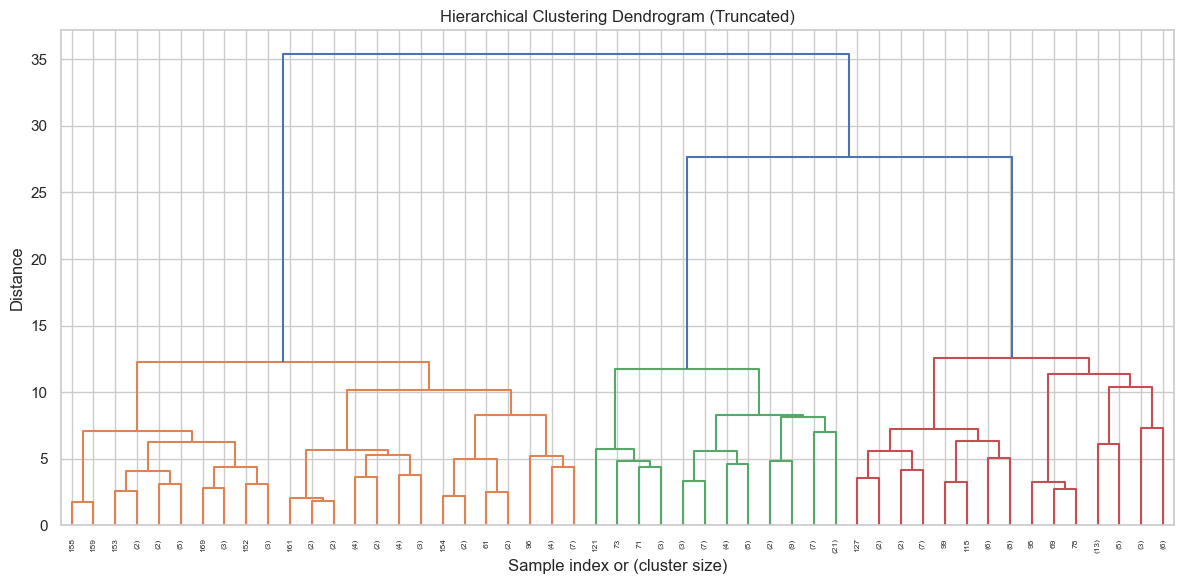

In [11]:
# Generate dendrogram using Ward linkage
Z = linkage(X_scaled, method="ward")

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=5)  # show only last few merges for clarity
plt.title("Hierarchical Clustering Dendrogram (Truncated)")
plt.xlabel("Sample index or (cluster size)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


### Interpretation of Hierarchical Clustering

To understand the structure of the Wine dataset, I applied Agglomerative Hierarchical Clustering (Ward linkage) and visualized the results using PCA-reduced data. I tested multiple values of `n_clusters` and reviewed the truncated dendrogram to identify meaningful grouping patterns.

### **Cluster Behavior Across Different n_clusters Values**

#### **n_clusters = 2**
The dataset is divided into two broad groups.  
This split captures the largest structural difference in the data, but the clusters are still fairly mixed.  
In the PCA scatterplot:
- Both clusters stretch across large regions,
- Some data points belonging to different underlying wine classes fall into the same cluster.

This suggests that **2 clusters is too coarse** for this dataset.

#### **n_clusters = 3**
This setting produces a much clearer and more meaningful separation.  
The PCA visualization shows three **visually distinct and compact clusters**:

- One group of points centered to the left (corresponding closely to Wine Class 0),
- A second group extending across the bottom-center (corresponding to Wine Class 1),
- A third group concentrated on the right side (corresponding to Wine Class 2).

This matches the true number of grape cultivars and shows the **cleanest, most natural cluster separation** among all tested values.  
**Three clusters best represent the underlying structure of the dataset.**

#### **n_clusters = 4**
At four clusters, the algorithm begins **splitting existing meaningful groups**:
- One of the major clusters gets divided into two subgroups,
- But these subgroups overlap substantially in PCA space.

The additional cluster does not reveal a new meaningful grouping; instead, it **over-partitions** the data.

#### **n_clusters = 5**
At five clusters, the over-partitioning becomes more pronounced:
- Several clusters occupy nearly the same PCA region,
- Some new clusters are small and not clearly separated,
- Visual overlap increases.

This indicates that **5 clusters fragments the natural structure** and does not provide additional useful insight.

### **Dendrogram Interpretation**

The truncated dendrogram further supports the conclusions drawn from the PCA plots:

- There are **large vertical jumps** in merge distances around the **~10–12 distance** level.  
  These jumps are strong indications of natural cluster boundaries.
- Cutting the dendrogram around this height yields approximately **3 clusters**, matching the PCA-based interpretation.
- Cutting at a lower height (around ~5) yields 4–5 clusters, which matches the more fragmented clusterings observed in the PCA scatterplots.
- The dendrogram also shows that the two largest jumps correspond to the separation of the left, center, and right PCA clusters — consistent with the presence of **three distinct groups** in the dataset.

### **Conclusion**

Across all visualizations and the dendrogram:

- **3 clusters** aligns best with the true wine classes and produces the clearest separation.
- **2 clusters** is too broad and mixes distinct groups.
- **4 or 5 clusters** over-split the data and produce overlapping or redundant clusters.
- Ward linkage hierarchical clustering reveals a natural three-group structure that reflects the true chemical differences among wine types.

Overall, **Agglomerative Clustering with n_clusters = 3** provides the most meaningful, interpretable, and well-separated clustering solution for the Wine dataset.


## Step 3: DBSCAN Clustering

In this step, I apply **DBSCAN** to the standardized wine data.  
I will:

- Experiment with different values of `eps` and `min_samples`.
- Visualize the resulting clusters and noise points in PCA space.
- Compute and report **Silhouette**, **Homogeneity**, and **Completeness** scores.


In [12]:
# Helper function to evaluate clustering results

def evaluate_clustering(labels, X_data, true_labels):
    """
    labels: cluster labels from clustering algorithm (e.g., DBSCAN)
    X_data: data used for clustering (e.g., X_scaled)
    true_labels: ground truth labels (for homogeneity/completeness)
    """
    unique_labels = set(labels)
    n_clusters = len(unique_labels - {-1})

    # Silhouette: only defined if at least 2 clusters and not all noise
    if n_clusters >= 2 and len(unique_labels) > 1:
        mask = labels != -1
        if mask.sum() > 1 and len(set(labels[mask])) > 1:
            sil = silhouette_score(X_data[mask], labels[mask])
        else:
            sil = np.nan
    else:
        sil = np.nan

    hom = homogeneity_score(true_labels, labels)
    comp = completeness_score(true_labels, labels)

    return n_clusters, sil, hom, comp


DBSCAN (eps=0.6, min_samples=5)
Number of clusters (excluding noise): 0
Silhouette score: nan
Homogeneity score: 0.0
Completeness score: 1.0


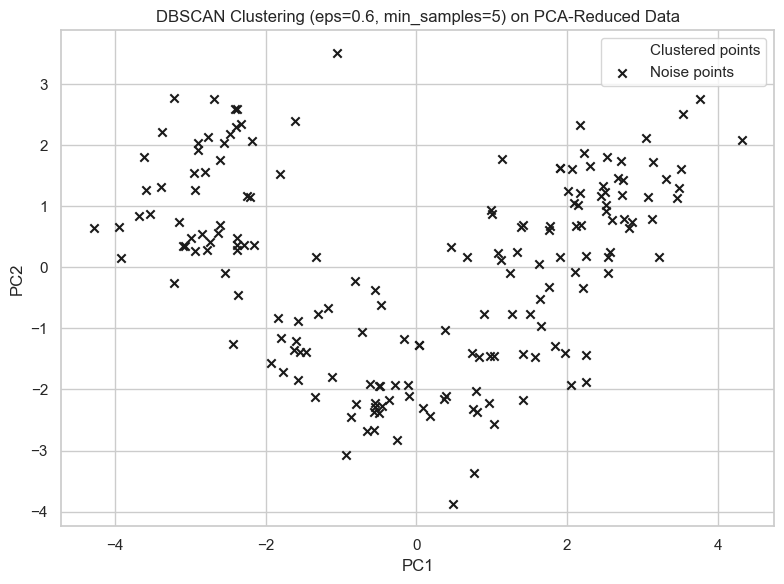

In [13]:
# First DBSCAN attempt
dbscan = DBSCAN(eps=0.6, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)

n_clusters_db, sil_db, hom_db, comp_db = evaluate_clustering(db_labels, X_scaled, y)

print("DBSCAN (eps=0.6, min_samples=5)")
print("Number of clusters (excluding noise):", n_clusters_db)
print("Silhouette score:", sil_db)
print("Homogeneity score:", hom_db)
print("Completeness score:", comp_db)

# Plot clusters and noise in PCA space
plt.figure()
mask_core = db_labels != -1
mask_noise = db_labels == -1

plt.scatter(X_pca[mask_core, 0], X_pca[mask_core, 1],
            c=db_labels[mask_core], cmap="tab10", label="Clustered points")
plt.scatter(X_pca[mask_noise, 0], X_pca[mask_noise, 1],
            c="k", marker="x", label="Noise points")

plt.title("DBSCAN Clustering (eps=0.6, min_samples=5) on PCA-Reduced Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# Experiment with multiple (eps, min_samples) combinations
eps_values = [0.4, 0.6, 0.8, 1.0]
min_samples_values = [3, 5, 10]

results = []

for eps_val in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps_val, min_samples=ms)
        labels = db.fit_predict(X_scaled)

        n_clusters, sil, hom, comp = evaluate_clustering(labels, X_scaled, y)
        n_noise = list(labels).count(-1)

        results.append({
            "eps": eps_val,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "silhouette": sil,
            "homogeneity": hom,
            "completeness": comp
        })

results_df = pd.DataFrame(results)
results_df


,eps,min_samples,n_clusters,n_noise,silhouette,homogeneity,completeness
0,0.4,3,0,178,NaN,0.0,1.0
1,0.4,5,0,178,NaN,0.0,1.0
2,0.4,10,0,178,NaN,0.0,1.0
3,0.6,3,0,178,NaN,0.0,1.0
4,0.6,5,0,178,NaN,0.0,1.0
5,0.6,10,0,178,NaN,0.0,1.0
6,0.8,3,0,178,NaN,0.0,1.0
7,0.8,5,0,178,NaN,0.0,1.0
8,0.8,10,0,178,NaN,0.0,1.0
9,1.0,3,0,178,NaN,0.0,1.0


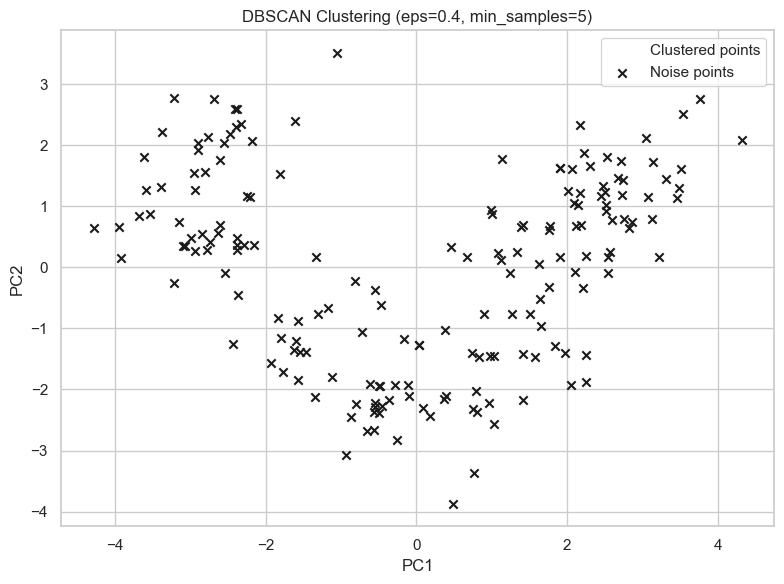

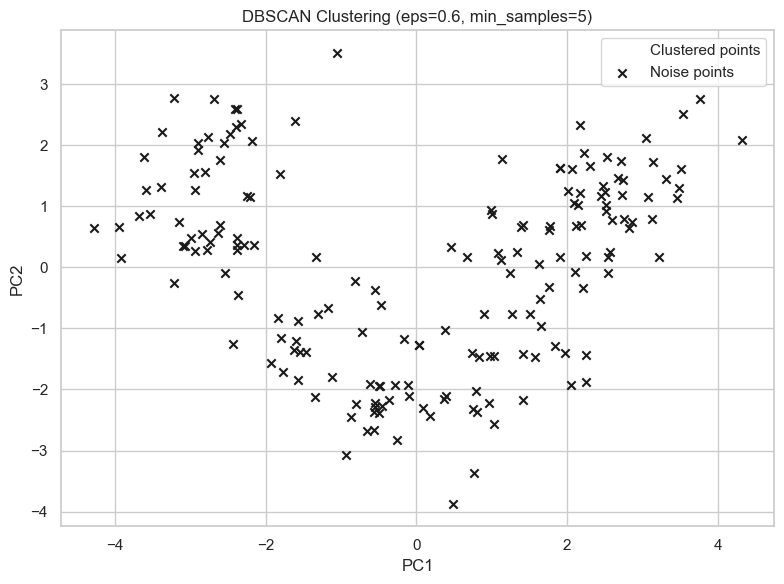

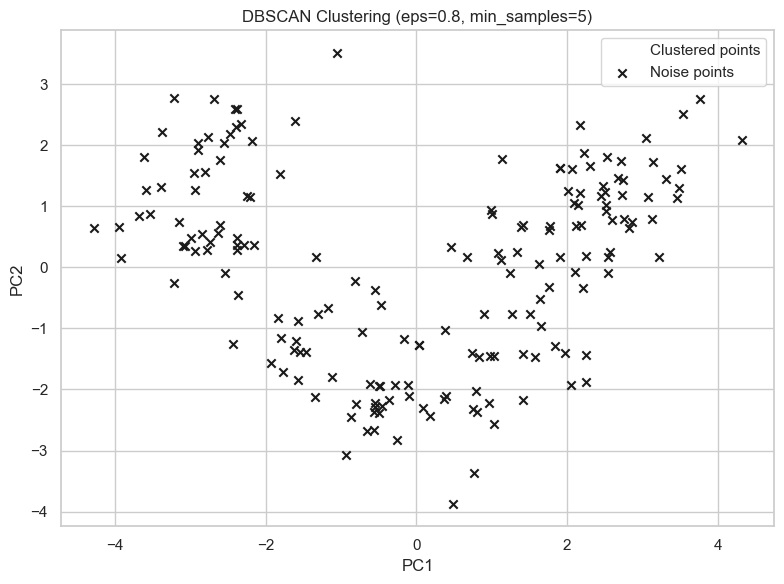

In [15]:
# Choose a few configurations to visualize
configs_to_plot = [
    (0.4, 5),
    (0.6, 5),
    (0.8, 5)
]

for eps_val, ms in configs_to_plot:
    db = DBSCAN(eps=eps_val, min_samples=ms)
    labels = db.fit_predict(X_scaled)

    plt.figure()
    mask_core = labels != -1
    mask_noise = labels == -1

    plt.scatter(X_pca[mask_core, 0], X_pca[mask_core, 1],
                c=labels[mask_core], cmap="tab10", label="Clustered points")
    plt.scatter(X_pca[mask_noise, 0], X_pca[mask_noise, 1],
                c="k", marker="x", label="Noise points")

    plt.title(f"DBSCAN Clustering (eps={eps_val}, min_samples={ms})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Interpretation of DBSCAN Clustering

To explore density-based clustering, I applied DBSCAN using several combinations of `eps` and `min_samples`.  
Across all parameter settings:

- `eps` values tested: **0.4, 0.6, 0.8, 1.0**  
- `min_samples` values tested: **3, 5, 10**

DBSCAN **failed to form any clusters** for every configuration tested.  
All **178 samples** were labeled as **noise (-1)**.

This result is clearly visible in the PCA scatterplots, where **every point is plotted as “noise” (X marker)**, regardless of the parameter choice.

### **Why Did DBSCAN Fail to Find Clusters?**

From the PCA visualization of the standardized Wine dataset, the distribution of points shows:

- The data is **continuous and smoothly spread out**, with **no strong density concentrations**.
- The three true classes (seen in the PCA plot colored by wine type) **do not form tight, dense pockets**.
- Instead, even the natural classes have **elongated, overlapping shapes**, which makes density-based separation difficult.

DBSCAN requires:
1. **High-density regions** to form clusters  
2. **Clear low-density gaps** to separate clusters  

However, the Wine dataset (in its 13D structure) does **not** contain strong density variations.  
As a result, every point was considered an outlier relative to DBSCAN’s neighborhood density requirements.

### **Effect of Parameter Choices**

#### **1. Varying eps (0.4 → 1.0)**
- Increasing `eps` enlarges the neighborhood radius.  
- However, even with `eps = 1.0`, DBSCAN still detected **no sufficiently dense regions**.
- The density of points in PCA (and in the standardized 13D space) is too uniform for any cluster to surpass the `min_samples` threshold.

#### **2. Varying min_samples (3 → 10)**
- Higher `min_samples` makes it even harder to form a cluster.
- Lower values (min_samples = 3) still resulted in **0 clusters**, meaning even very small dense pockets do not exist in this dataset.

Across **all 12 parameter combinations**, the output was:



## Step 4: Comparison and Insights

### Overview
In this final step, I compare the clustering results from **Agglomerative Hierarchical Clustering** and **DBSCAN**, evaluate how parameter choices influenced both algorithms, and summarize the strengths and weaknesses of each method based on their performance on the Wine dataset.

## **Hierarchical vs. DBSCAN: Key Differences**

### **1. Number and Quality of Clusters**

#### **Hierarchical Clustering**
- Produced meaningful and visually distinct clusters.
- `n_clusters = 3` resulted in the **clearest and most natural grouping**, closely matching the three true wine classes.
- Clusters were compact and well-separated in PCA space.
- Increasing to 4 or 5 clusters caused over-segmentation and created unnecessary splits.

#### **DBSCAN**
- Across **all 12 parameter combinations** (`eps = 0.4–1.0`, `min_samples = 3, 5, 10`), DBSCAN found:
  - **0 clusters**
  - **178 noise points**
- Every point was labeled as noise, producing no meaningful grouping.
- Even with a larger `eps = 1.0`, DBSCAN still failed to identify any dense regions.

**Conclusion:**  
Hierarchical clustering was able to extract a clear cluster structure from the data, while DBSCAN could not identify any clusters at all.

## **2. Influence of Parameters**

### **Hierarchical Clustering Parameters**
- Changing `n_clusters` directly changed the granularity of grouping.
- A cut in the dendrogram around **distance ~10–12** produced approximately **3 natural clusters**, which matched the PCA visual separation.
- Increasing `n_clusters` beyond 3 led to over-fragmentation rather than new insights.

### **DBSCAN Parameters**
- **eps**:
  - Low values (`0.4`) were too strict → all samples considered noise.
  - Higher values (`0.8` and `1.0`) still could not gather enough points to meet `min_samples`.
- **min_samples**:
  - Higher values (10) made clustering even less likely.
  - Even with `min_samples = 3`, no clusters formed.

**Why DBSCAN failed:**  
The Wine dataset lacks distinct high-density regions and instead forms overlapping and smoothly distributed clusters.  
DBSCAN requires **clear density differences**, which this dataset does not have.

## **3. Strengths and Weaknesses of the Algorithms**

### **Hierarchical Clustering**
**Strengths:**
- Produces a dendrogram that reveals the entire cluster structure.
- Performs well when clusters are relatively compact and separated.
- Does not require density assumptions.
- Naturally suggested the correct number of clusters (3).

**Weaknesses:**
- Sensitive to noise and outliers since every point must belong to a cluster.
- Can become computationally expensive for very large datasets.

### **DBSCAN**
**Strengths:**
- Excellent for finding clusters with arbitrary shapes.
- Automatically identifies noise points.
- Does not require specifying the number of clusters in advance.

**Weaknesses (as shown in this dataset):**
- Performs poorly when the data has **no strong density variations**.
- Highly sensitive to `eps` and `min_samples`.
- Can label all points as noise when density is uniform—exactly what happened here.

## **4. Overall Reflection**

- **Hierarchical Clustering** succeeded in identifying the natural grouping of the Wine dataset and provided interpretable visual clusters.
- **DBSCAN** was not appropriate for this dataset due to the lack of density-separated regions, resulting in no clusters formed under all tested parameters.
- This comparison highlights the importance of choosing a clustering algorithm that matches the **data’s intrinsic structure**.
- For structured, compact clusters (like Wine), hierarchical methods work well.  
  For datasets with irregular shapes and clear density drops, DBSCAN is the better choice.
